In [1]:
!pip install pgmpy

In [2]:
!pip install daft

In [3]:
from pgmpy.models import BayesianNetwork
from pgmpy.inference import VariableElimination
from pgmpy.factors.discrete import TabularCPD
from pgmpy.inference import CausalInference

<Axes:>

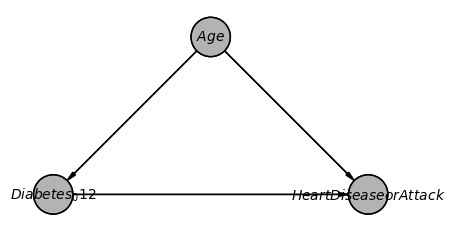

In [4]:
simp_model = BayesianNetwork([("Diabetes_012", "HeartDiseaseorAttack"), ("Age","HeartDiseaseorAttack"), ("Age","Diabetes_012")])
simp_model.to_daft(node_pos={"Diabetes_012": (0, 0), "HeartDiseaseorAttack": (4, 0), "Age": (2, 2)}).render()

In [5]:
cpd_s = TabularCPD(
    variable="Age", variable_card=4, values=[[0.17178985],[0.42913625],[0.33926982],[0.059804097]], state_names={"Age": ["Mid Adult", "Old Adult","Senior","Young Adult"]}
)
cpd_t = TabularCPD(
    variable="Diabetes_012",
    variable_card=2,
    values=[[0.95023847,0.86479086, 0.80115485, 0.98630136], [0.04976156, 0.13520916, 0.19884515, 0.01369863]],
    evidence=["Age"],
    evidence_card=[4],
    state_names={"Age": ["Mid Adult", "Old Adult","Senior","Young Adult"], "Diabetes_012": [0, 1]},
)
cpd_c = TabularCPD(
    variable="HeartDiseaseorAttack",
    variable_card=2,
    values=[[0.98690814,0.97083336,0.950955,0.83609575,0.858341,0.7412883,0.9933575,0.95652175,], [0.013091861,0.029166667,0.049045015,0.16390423,0.14165902,0.25871173,0.006642512,0.04347826]],
    evidence=["Age", "Diabetes_012"],
    evidence_card=[4,2],
    state_names={"Age": ["Mid Adult", "Old Adult","Senior","Young Adult"], "Diabetes_012": [0, 1], "HeartDiseaseorAttack": [0, 1]},
)

simp_model.add_cpds(cpd_s, cpd_t, cpd_c)

In [6]:
print(simp_model.get_cpds("Age"))

+------------------+-----------+
| Age(Mid Adult)   | 0.17179   |
+------------------+-----------+
| Age(Old Adult)   | 0.429136  |
+------------------+-----------+
| Age(Senior)      | 0.33927   |
+------------------+-----------+
| Age(Young Adult) | 0.0598041 |
+------------------+-----------+


In [7]:
print(simp_model.get_cpds("Diabetes_012"))

+-----------------+----------------+-----+-------------+------------------+
| Age             | Age(Mid Adult) | ... | Age(Senior) | Age(Young Adult) |
+-----------------+----------------+-----+-------------+------------------+
| Diabetes_012(0) | 0.95023847     | ... | 0.80115485  | 0.98630136       |
+-----------------+----------------+-----+-------------+------------------+
| Diabetes_012(1) | 0.04976156     | ... | 0.19884515  | 0.01369863       |
+-----------------+----------------+-----+-------------+------------------+


In [8]:
print(simp_model.get_cpds("HeartDiseaseorAttack"))

+-------------------------+-----+------------------+
| Age                     | ... | Age(Young Adult) |
+-------------------------+-----+------------------+
| Diabetes_012            | ... | Diabetes_012(1)  |
+-------------------------+-----+------------------+
| HeartDiseaseorAttack(0) | ... | 0.95652175       |
+-------------------------+-----+------------------+
| HeartDiseaseorAttack(1) | ... | 0.04347826       |
+-------------------------+-----+------------------+


Calculate unconditional distribution of recovery without any evidence.

In [9]:
infer_non_adjust = VariableElimination(simp_model)
print(infer_non_adjust.query(variables=["HeartDiseaseorAttack"]))

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

+-------------------------+-----------------------------+
| HeartDiseaseorAttack    |   phi(HeartDiseaseorAttack) |
+=========================+=============================+
| HeartDiseaseorAttack(0) |                      0.9135 |
+-------------------------+-----------------------------+
| HeartDiseaseorAttack(1) |                      0.0865 |
+-------------------------+-----------------------------+


In [10]:
#infer_non_adjust = VariableElimination(simp_model)
print(infer_non_adjust.query(variables=["HeartDiseaseorAttack"], evidence={"Diabetes_012": 1}))
print(infer_non_adjust.query(variables=["Age"], evidence={"Diabetes_012": 1}))

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

+-------------------------+-----------------------------+
| HeartDiseaseorAttack    |   phi(HeartDiseaseorAttack) |
+=========================+=============================+
| HeartDiseaseorAttack(0) |                      0.7979 |
+-------------------------+-----------------------------+
| HeartDiseaseorAttack(1) |                      0.2021 |
+-------------------------+-----------------------------+


0it [00:00, ?it/s]

0it [00:00, ?it/s]

+------------------+------------+
| Age              |   phi(Age) |
+==================+============+
| Age(Mid Adult)   |     0.0634 |
+------------------+------------+
| Age(Old Adult)   |     0.4303 |
+------------------+------------+
| Age(Senior)      |     0.5003 |
+------------------+------------+
| Age(Young Adult) |     0.0061 |
+------------------+------------+


In [11]:
print(infer_non_adjust.query(variables=["HeartDiseaseorAttack"], evidence={"Diabetes_012": 0}))
print(infer_non_adjust.query(variables=["Age"], evidence={"Diabetes_012": 0}))

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

+-------------------------+-----------------------------+
| HeartDiseaseorAttack    |   phi(HeartDiseaseorAttack) |
+=========================+=============================+
| HeartDiseaseorAttack(0) |                      0.9315 |
+-------------------------+-----------------------------+
| HeartDiseaseorAttack(1) |                      0.0685 |
+-------------------------+-----------------------------+


0it [00:00, ?it/s]

0it [00:00, ?it/s]

+------------------+------------+
| Age              |   phi(Age) |
+==================+============+
| Age(Mid Adult)   |     0.1887 |
+------------------+------------+
| Age(Old Adult)   |     0.4290 |
+------------------+------------+
| Age(Senior)      |     0.3142 |
+------------------+------------+
| Age(Young Adult) |     0.0682 |
+------------------+------------+


So, what if the variable "S" is fixed as well?

In [12]:
print(infer_non_adjust.query(variables=["HeartDiseaseorAttack"], evidence={"Diabetes_012": 1,"Age": "Senior"}))

0it [00:00, ?it/s]

0it [00:00, ?it/s]

+-------------------------+-----------------------------+
| HeartDiseaseorAttack    |   phi(HeartDiseaseorAttack) |
+=========================+=============================+
| HeartDiseaseorAttack(0) |                      0.7413 |
+-------------------------+-----------------------------+
| HeartDiseaseorAttack(1) |                      0.2587 |
+-------------------------+-----------------------------+


In [13]:
print(infer_non_adjust.query(variables=["HeartDiseaseorAttack"], evidence={"Diabetes_012": 0,"Age":"Senior"}))

0it [00:00, ?it/s]

0it [00:00, ?it/s]

+-------------------------+-----------------------------+
| HeartDiseaseorAttack    |   phi(HeartDiseaseorAttack) |
+=========================+=============================+
| HeartDiseaseorAttack(0) |                      0.8583 |
+-------------------------+-----------------------------+
| HeartDiseaseorAttack(1) |                      0.1417 |
+-------------------------+-----------------------------+


In [14]:
print(infer_non_adjust.query(variables=["HeartDiseaseorAttack"], evidence={"Diabetes_012": 1,"Age": "Old Adult"}))
print(infer_non_adjust.query(variables=["HeartDiseaseorAttack"], evidence={"Diabetes_012": 0,"Age": "Old Adult"}))

0it [00:00, ?it/s]

0it [00:00, ?it/s]

+-------------------------+-----------------------------+
| HeartDiseaseorAttack    |   phi(HeartDiseaseorAttack) |
+=========================+=============================+
| HeartDiseaseorAttack(0) |                      0.8361 |
+-------------------------+-----------------------------+
| HeartDiseaseorAttack(1) |                      0.1639 |
+-------------------------+-----------------------------+


0it [00:00, ?it/s]

0it [00:00, ?it/s]

+-------------------------+-----------------------------+
| HeartDiseaseorAttack    |   phi(HeartDiseaseorAttack) |
+=========================+=============================+
| HeartDiseaseorAttack(0) |                      0.9510 |
+-------------------------+-----------------------------+
| HeartDiseaseorAttack(1) |                      0.0490 |
+-------------------------+-----------------------------+


In [15]:
print(infer_non_adjust.query(variables=["HeartDiseaseorAttack"], evidence={"Diabetes_012": 1,"Age": "Mid Adult"}))
print(infer_non_adjust.query(variables=["HeartDiseaseorAttack"], evidence={"Diabetes_012": 0,"Age": "Mid Adult"}))

0it [00:00, ?it/s]

0it [00:00, ?it/s]

+-------------------------+-----------------------------+
| HeartDiseaseorAttack    |   phi(HeartDiseaseorAttack) |
+=========================+=============================+
| HeartDiseaseorAttack(0) |                      0.9708 |
+-------------------------+-----------------------------+
| HeartDiseaseorAttack(1) |                      0.0292 |
+-------------------------+-----------------------------+


0it [00:00, ?it/s]

0it [00:00, ?it/s]

+-------------------------+-----------------------------+
| HeartDiseaseorAttack    |   phi(HeartDiseaseorAttack) |
+=========================+=============================+
| HeartDiseaseorAttack(0) |                      0.9869 |
+-------------------------+-----------------------------+
| HeartDiseaseorAttack(1) |                      0.0131 |
+-------------------------+-----------------------------+


In [16]:
print(infer_non_adjust.query(variables=["HeartDiseaseorAttack"], evidence={"Diabetes_012": 1,"Age": "Young Adult"}))
print(infer_non_adjust.query(variables=["HeartDiseaseorAttack"], evidence={"Diabetes_012": 0,"Age": "Young Adult"}))

0it [00:00, ?it/s]

0it [00:00, ?it/s]

+-------------------------+-----------------------------+
| HeartDiseaseorAttack    |   phi(HeartDiseaseorAttack) |
+=========================+=============================+
| HeartDiseaseorAttack(0) |                      0.9565 |
+-------------------------+-----------------------------+
| HeartDiseaseorAttack(1) |                      0.0435 |
+-------------------------+-----------------------------+


0it [00:00, ?it/s]

0it [00:00, ?it/s]

+-------------------------+-----------------------------+
| HeartDiseaseorAttack    |   phi(HeartDiseaseorAttack) |
+=========================+=============================+
| HeartDiseaseorAttack(0) |                      0.9934 |
+-------------------------+-----------------------------+
| HeartDiseaseorAttack(1) |                      0.0066 |
+-------------------------+-----------------------------+


The key observation is: Age is a confounding factor

Create a new DAG by applying "do(T=1)" to the model. Plot the new DAG.

In [17]:
do_Diabetes=simp_model.do(['Diabetes_012'])

<Axes:>

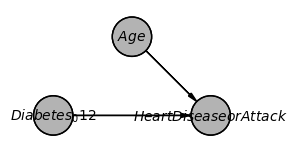

In [18]:
do_Diabetes.to_daft(node_pos={"Diabetes_012": (0, 0), "HeartDiseaseorAttack": (2, 0), "Age": (1, 1)}).render()

Making "do(T=1)" removes dependence of selection for treatment on age. The initial unconditional ditribution of "Age" remains unchanged, of course. Other unconditional distributions, except for the node "Diabetes_012" are also the same.

In [19]:
print(do_Diabetes.get_cpds("Age"))

+------------------+-----------+
| Age(Mid Adult)   | 0.17179   |
+------------------+-----------+
| Age(Old Adult)   | 0.429136  |
+------------------+-----------+
| Age(Senior)      | 0.33927   |
+------------------+-----------+
| Age(Young Adult) | 0.0598041 |
+------------------+-----------+


In [20]:
print(do_Diabetes.get_cpds("Diabetes_012"))

+-----------------+-----------+
| Diabetes_012(0) | 0.900621  |
+-----------------+-----------+
| Diabetes_012(1) | 0.0993786 |
+-----------------+-----------+


In [21]:
print(do_Diabetes.get_cpds("HeartDiseaseorAttack"))

+-------------------------+-----+------------------+
| Age                     | ... | Age(Young Adult) |
+-------------------------+-----+------------------+
| Diabetes_012            | ... | Diabetes_012(1)  |
+-------------------------+-----+------------------+
| HeartDiseaseorAttack(0) | ... | 0.95652175       |
+-------------------------+-----+------------------+
| HeartDiseaseorAttack(1) | ... | 0.04347826       |
+-------------------------+-----+------------------+


Presenting evidence to the mutilated graph gives the following:

evidence={"Diabetes": 0}

In [22]:
infer_do_Diabetes= CausalInference(do_Diabetes)
print(infer_do_Diabetes.query(variables=["HeartDiseaseorAttack"], evidence={"Diabetes_012": 0}))

+-------------------------+-----------------------------+
| HeartDiseaseorAttack    |   phi(HeartDiseaseorAttack) |
+=========================+=============================+
| HeartDiseaseorAttack(0) |                      0.9282 |
+-------------------------+-----------------------------+
| HeartDiseaseorAttack(1) |                      0.0718 |
+-------------------------+-----------------------------+


evidence={"Diabetes": 1}

In [23]:
print(infer_do_Diabetes.query(variables=["HeartDiseaseorAttack"], evidence={"Diabetes_012": 1}))

+-------------------------+-----------------------------+
| HeartDiseaseorAttack    |   phi(HeartDiseaseorAttack) |
+=========================+=============================+
| HeartDiseaseorAttack(0) |                      0.8343 |
+-------------------------+-----------------------------+
| HeartDiseaseorAttack(1) |                      0.1657 |
+-------------------------+-----------------------------+


While state distribution of the node "Age" remains unchanged.

In [24]:
print(infer_do_Diabetes.query(variables=["Age"], evidence={"Diabetes_012": 0}))

+------------------+------------+
| Age              |   phi(Age) |
+==================+============+
| Age(Mid Adult)   |     0.1718 |
+------------------+------------+
| Age(Old Adult)   |     0.4291 |
+------------------+------------+
| Age(Senior)      |     0.3393 |
+------------------+------------+
| Age(Young Adult) |     0.0598 |
+------------------+------------+


In [25]:
print(infer_do_Diabetes.query(variables=["Age"], evidence={"Diabetes_012": 1}))

+------------------+------------+
| Age              |   phi(Age) |
+==================+============+
| Age(Mid Adult)   |     0.1718 |
+------------------+------------+
| Age(Old Adult)   |     0.4291 |
+------------------+------------+
| Age(Senior)      |     0.3393 |
+------------------+------------+
| Age(Young Adult) |     0.0598 |
+------------------+------------+


Calculate the causal effect as Average Causal Effect (ACE), a.k.a. Average Treatment Effect (ATE), which is
P
(
R
=
1
|
d
o
(
T
=
1
)
)
−
P
(
R
=
1
|
d
o
(
T
=
0
)
)
.
First, simulate new data using the mutilated model do_T.


In [26]:
mm_do_Diabetes=do_Diabetes.simulate(n_samples=10000)
print(mm_do_Diabetes)

  0%|          | 0/3 [00:00<?, ?it/s]

      Diabetes_012  HeartDiseaseorAttack        Age
0                0                     0  Old Adult
1                0                     0  Old Adult
2                1                     0  Mid Adult
3                0                     0     Senior
4                0                     1     Senior
...            ...                   ...        ...
9995             0                     0     Senior
9996             0                     0  Old Adult
9997             0                     0  Old Adult
9998             0                     0     Senior
9999             0                     1     Senior

[10000 rows x 3 columns]


/opt/anaconda3/lib/python3.9/site-packages/pgmpy/utils/mathext.py:83: UserWarning: Probability values don't exactly sum to 1. Differ by: -1.7000000074318677e-08. Adjusting values.
  warn(
/opt/anaconda3/lib/python3.9/site-packages/pgmpy/models/BayesianNetwork.py:1227: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return samples.loc[:, set(self.nodes()) - self.latents]


Then do the inference using estimate_ate().

In [27]:
#import pandas as pd

In [28]:
#mm_do_Diabetes = pd.get_dummies(mm_do_Diabetes, columns=['Age','HeartDiseaseorAttack'])

In [29]:
mm_do_Diabetes

,Diabetes_012,HeartDiseaseorAttack,Age
0,0,0,Old Adult
1,0,0,Old Adult
2,1,0,Mid Adult
3,0,0,Senior
4,0,1,Senior
...,...,...,...
9995,0,0,Senior
9996,0,0,Old Adult
9997,0,0,Old Adult
9998,0,0,Senior


In [30]:
mm_do_Diabetes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Diabetes_012          10000 non-null  int64 
 1   HeartDiseaseorAttack  10000 non-null  int64 
 2   Age                   10000 non-null  object
dtypes: int64(2), object(1)
memory usage: 234.5+ KB


In [31]:
inference = CausalInference(model=do_Diabetes)
inference.estimate_ate("Diabetes_012", "HeartDiseaseorAttack", data=mm_do_Diabetes, estimator_type="linear")

0.1064117111222927